# Final Project

### Import Packages

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import math
from sklearn.metrics import mean_squared_error

### Import Dataset

To attain our objective of predicting demand and setting a dynamic pricing strategy accordingly, we will need a dataset that collects historical reservations of a hotel. We used an online hotel reservation dataset available on Kaggle by Ahsan Raza containing 36,275 observations and 19 columns collected between 2017 and 2019.

In [2]:
df = pd.read_csv("Hotel Reservations.csv")
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


# Estimate Demand

The first objective is to build a regression model to estimate demand. Once the data has been clean, we will try to find the attributes in the data that may affect the demand and add them to the model. Then, we will have to compare models to find the one that best compromises on the bias VS. variance tradeoff. 

### Clean Data 

In [3]:
# remove cancellations
df = df[df["booking_status"] != "Canceled"]

# remove 0 price 
df = df[df['avg_price_per_room'] != 0]
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
6,INN00007,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,2017,10,15,Online,0,0,0,107.55,1,Not_Canceled
7,INN00008,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,2018,12,26,Online,0,0,0,105.61,1,Not_Canceled
8,INN00009,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,2018,7,6,Offline,0,0,0,96.90,1,Not_Canceled


#### Add arrivals

Now, to estimate how demand gets affected by different factors, we must identify the flow of hotel reservations (i.e., identify from when to when are customers staying). 

In [4]:
# Add Date as a column 
df['date'] = df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str).str.zfill(2) + '-' + df['arrival_date'].astype(str).str.zfill(2)
df['date'] = pd.to_datetime(df['date'], errors = 'coerce')

# Add total nights spent as a column
df['no_of_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']

# identify that these are arrivals 
df["arrivals"] = 1
df['depart'] = 0 
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,date,no_of_nights,arrivals,depart
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,...,0,0,0,65.00,0,Not_Canceled,2017-10-02,3,1,0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,...,0,0,0,106.68,1,Not_Canceled,2018-11-06,5,1,0
6,INN00007,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,2017,...,0,0,0,107.55,1,Not_Canceled,2017-10-15,4,1,0
7,INN00008,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,2018,...,0,0,0,105.61,1,Not_Canceled,2018-12-26,4,1,0
8,INN00009,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,2018,...,0,0,0,96.90,1,Not_Canceled,2018-07-06,4,1,0


#### Add departures

In [5]:
# create a copy of the original dataframe
df_orig = df.copy()

# modify the original dataframe
df_orig['date'] = df_orig['date'] + pd.to_timedelta(df_orig['no_of_nights'], unit = 'd')  # add no_of_nights to arrival_date
df_orig['arrivals'] = 0  # set arrivals to 0
df_orig['depart'] = 1 # set departures to 1 

# duplicate each row in the original dataframe and concatenate it with the modified copy
df_dup = pd.concat([df, df_orig], ignore_index = True)

# sort by date to see the flow 
df_dup = df_dup.sort_values(by = 'arrival_date')
df_dup.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,date,no_of_nights,arrivals,depart
44524,INN31391,2,0,2,4,Meal Plan 1,0,Room_Type 1,238,2018,...,0,0,0,94.07,1,Not_Canceled,2018-09-07,6,0,1
10783,INN16296,2,0,1,2,Not Selected,0,Room_Type 1,67,2018,...,0,0,0,81.90,0,Not_Canceled,2018-04-01,3,1,0
36290,INN18809,2,0,1,3,Meal Plan 1,0,Room_Type 1,159,2018,...,0,0,0,99.45,1,Not_Canceled,2018-08-05,4,0,1
10773,INN16281,1,0,0,1,Meal Plan 1,0,Room_Type 1,1,2018,...,0,0,0,96.00,1,Not_Canceled,2018-03-01,1,1,0
18560,INN28219,1,0,0,5,Meal Plan 1,0,Room_Type 1,8,2018,...,0,0,0,65.00,0,Not_Canceled,2018-03-01,5,1,0


Now we can start looking at the potential attributes. 

### Seasonality

Our first hypothesis for which variables may affect demand is seasonality. From our current understanding of hotels, there are fluctuations according to the time of the year. 

In [6]:
# find arrivals and departure for each day 
df_season = df_dup.groupby('date').agg({'arrivals': 'sum', 'depart': 'sum'})

# calculate the difference between arrival and depart
df_season['flow'] = df_season['arrivals'] - df_season['depart']

# calculate the running total of the differences
df_season['running_total'] = df_season['flow'].cumsum()
df_season = df_season.reset_index()
df_season

,date,arrivals,depart,flow,running_total
0,2017-07-01,15,0,15,15
1,2017-07-03,1,14,-13,2
2,2017-07-07,4,1,3,5
3,2017-07-08,2,0,2,7
4,2017-07-09,1,1,0,7
...,...,...,...,...,...
547,2019-01-04,0,19,-19,10
548,2019-01-05,0,5,-5,5
549,2019-01-06,0,3,-3,2
550,2019-01-07,0,1,-1,1


#### Plot time series

So now, what does it looks like visually...

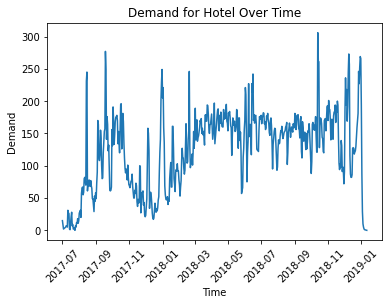

In [7]:
# plot time series 
plt.plot(df_season["date"], df_season["running_total"])

# formatting 
plt.title("Demand for Hotel Over Time")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.xticks(rotation = 45)
plt.show()

There seems to be fluctuations in demand according to the time of the year. Let's confirm with the data. 

In [8]:
# add each day of the year as a column 
df_dup['month_day'] = df_dup['date'].dt.strftime('%m-%d')
df_dup.head()

# find arrivals and departure for each day of a year
df_season = df_dup.groupby('month_day').agg({'arrivals': 'sum'})
df_season.sort_values(by='arrivals', ascending = False)

,arrivals
month_day,
10-13,287
09-18,251
08-14,233
10-02,204
10-16,184
...,...
06-05,13
01-13,12
02-02,10


As it can be seen, the very high demand times usually are all in the same month and the same goes for the very low demand moments. Therefore, we will add a "month-seasonality" factor to the data.

In [9]:
df_dup['month'] = df_dup['date'].dt.month
df_dup.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,date,no_of_nights,arrivals,depart,month_day,month
44524,INN31391,2,0,2,4,Meal Plan 1,0,Room_Type 1,238,2018,...,0,94.07,1,Not_Canceled,2018-09-07,6,0,1,09-07,9.0
10783,INN16296,2,0,1,2,Not Selected,0,Room_Type 1,67,2018,...,0,81.90,0,Not_Canceled,2018-04-01,3,1,0,04-01,4.0
36290,INN18809,2,0,1,3,Meal Plan 1,0,Room_Type 1,159,2018,...,0,99.45,1,Not_Canceled,2018-08-05,4,0,1,08-05,8.0
10773,INN16281,1,0,0,1,Meal Plan 1,0,Room_Type 1,1,2018,...,0,96.00,1,Not_Canceled,2018-03-01,1,1,0,03-01,3.0
18560,INN28219,1,0,0,5,Meal Plan 1,0,Room_Type 1,8,2018,...,0,65.00,0,Not_Canceled,2018-03-01,5,1,0,03-01,3.0


### Trend in Room Type

The second potential category which can affect demand if the room type. 

In [10]:
# find arrivals and departure for each day 
df_room = df_dup.groupby('room_type_reserved').agg({'arrivals': 'sum'})

# show df
df_room = df_room.reset_index()
df_room

,room_type_reserved,arrivals
0,Room_Type 1,18676
1,Room_Type 2,439
2,Room_Type 3,3
3,Room_Type 4,3931
4,Room_Type 5,176
5,Room_Type 6,544
6,Room_Type 7,82


Let's look at it visually...

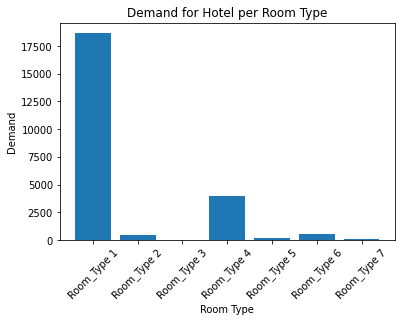

In [11]:
# plot 
plt.bar(x = df_room["room_type_reserved"], height = df_room["arrivals"])

# format
plt.title("Demand for Hotel per Room Type")
plt.xlabel("Room Type")
plt.ylabel("Demand")
plt.xticks(rotation = 45)
plt.show()

As it can be seen, there are high variations in demand according to the type of room reserved; therefore, Room Type will be added to the model. 

However, as it can be see there are some Room Types with a very low number of observations. For now, we will only drop Room Type 3 which only has three observations. 

In [12]:
df_dup = df_dup[df_dup["room_type_reserved"] != "Room_Type 3"]
df_dup.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,date,no_of_nights,arrivals,depart,month_day,month
44524,INN31391,2,0,2,4,Meal Plan 1,0,Room_Type 1,238,2018,...,0,94.07,1,Not_Canceled,2018-09-07,6,0,1,09-07,9.0
10783,INN16296,2,0,1,2,Not Selected,0,Room_Type 1,67,2018,...,0,81.90,0,Not_Canceled,2018-04-01,3,1,0,04-01,4.0
36290,INN18809,2,0,1,3,Meal Plan 1,0,Room_Type 1,159,2018,...,0,99.45,1,Not_Canceled,2018-08-05,4,0,1,08-05,8.0
10773,INN16281,1,0,0,1,Meal Plan 1,0,Room_Type 1,1,2018,...,0,96.00,1,Not_Canceled,2018-03-01,1,1,0,03-01,3.0
18560,INN28219,1,0,0,5,Meal Plan 1,0,Room_Type 1,8,2018,...,0,65.00,0,Not_Canceled,2018-03-01,5,1,0,03-01,3.0


### Price and Demand 

In [13]:
# find arrivals and departure for each day 
df_price = df_dup[df_dup["room_type_reserved"] == "Room_Type 1"]
df_price = df_price.groupby('avg_price_per_room').agg({'arrivals': 'sum'})

# show df
df_price = df_price.reset_index()
df_price

,avg_price_per_room,arrivals
0,0.50,1
1,1.00,8
2,2.00,6
3,3.00,2
4,4.50,1
...,...,...
2208,207.00,1
2209,208.83,1
2210,210.00,1
2211,215.50,1


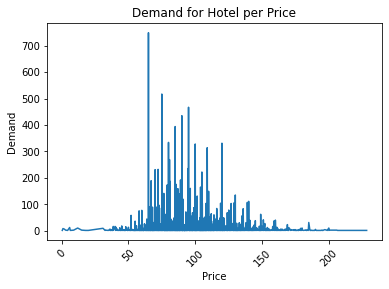

In [14]:
# plot 
plt.plot(df_price["avg_price_per_room"], df_price["arrivals"])

# format
plt.title("Demand for Hotel per Price")
plt.xlabel("Price")
plt.ylabel("Demand")
plt.xticks(rotation = 45)
plt.show()

We can see the data being slighly skewed towards the right showing that lower price may bring a larger amount of customers. Therefore, price will be added to the model.

### Prepare Data For Model 

#### Convert to weeks

We want to estimate the weekly demand. 

In [15]:
df_dup['week'] = df_dup['date'].dt.week
df_dup.head()

/var/folders/zw/fqrrp0nj2jj2nb862n366m6c0000gn/T/ipykernel_22357/2972673422.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_dup['week'] = df_dup['date'].dt.week


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,avg_price_per_room,no_of_special_requests,booking_status,date,no_of_nights,arrivals,depart,month_day,month,week
44524,INN31391,2,0,2,4,Meal Plan 1,0,Room_Type 1,238,2018,...,94.07,1,Not_Canceled,2018-09-07,6,0,1,09-07,9.0,36.0
10783,INN16296,2,0,1,2,Not Selected,0,Room_Type 1,67,2018,...,81.90,0,Not_Canceled,2018-04-01,3,1,0,04-01,4.0,13.0
36290,INN18809,2,0,1,3,Meal Plan 1,0,Room_Type 1,159,2018,...,99.45,1,Not_Canceled,2018-08-05,4,0,1,08-05,8.0,31.0
10773,INN16281,1,0,0,1,Meal Plan 1,0,Room_Type 1,1,2018,...,96.00,1,Not_Canceled,2018-03-01,1,1,0,03-01,3.0,9.0
18560,INN28219,1,0,0,5,Meal Plan 1,0,Room_Type 1,8,2018,...,65.00,0,Not_Canceled,2018-03-01,5,1,0,03-01,3.0,9.0


#### Split the dataset

In [16]:
# training dataset 
train = df_dup[(df_dup['date'] >= '2017-08-15') & (df_dup['date'] < '2018-08-15')]
train = train[train['arrivals'] == 1]

# test dataset 
test = df_dup[(df_dup['date'] >= '2018-08-15') & (df_dup['date'] < '2018-12-15')]
test = test[test['arrivals'] == 1]

#### Organize Data by Week and Room Type (Panel Data)

In [17]:
# find arrivals and departure for each day 
df = train.groupby(['week', 'month', 'room_type_reserved']).agg({'arrivals': 'sum', 'avg_price_per_room': 'mean'})
df = df.reset_index()
df.head()

,week,month,room_type_reserved,arrivals,avg_price_per_room
0,1.0,1.0,Room_Type 1,178,82.086517
1,1.0,1.0,Room_Type 2,16,70.525000
2,1.0,1.0,Room_Type 4,17,87.940588
3,1.0,1.0,Room_Type 5,1,6.000000
4,1.0,1.0,Room_Type 6,5,163.430000


#### Add Price in Week t - 1 and t - 2

Is there a relationship between previous prices and current demand?

In [18]:
# group the data by type and create a new column with the previous week's price data for each type
df['Price t-1'] = df.groupby('room_type_reserved')['avg_price_per_room'].shift(1)
df['Price t-2'] = df.groupby('room_type_reserved')['avg_price_per_room'].shift(2)

# fill nan's with first price point
df['Price t-1'] = df.groupby('room_type_reserved')['avg_price_per_room'].shift(1).fillna(df.groupby('room_type_reserved')['avg_price_per_room'].transform('first'))
df['Price t-2'] = df.groupby('room_type_reserved')['avg_price_per_room'].shift(2).fillna(df.groupby('room_type_reserved')['avg_price_per_room'].transform('first'))

# display the resulting dataframe
df

,week,month,room_type_reserved,arrivals,avg_price_per_room,Price t-1,Price t-2
0,1.0,1.0,Room_Type 1,178,82.086517,82.086517,82.086517
1,1.0,1.0,Room_Type 2,16,70.525000,70.525000,70.525000
2,1.0,1.0,Room_Type 4,17,87.940588,87.940588,87.940588
3,1.0,1.0,Room_Type 5,1,6.000000,6.000000,6.000000
4,1.0,1.0,Room_Type 6,5,163.430000,163.430000,163.430000
...,...,...,...,...,...,...,...
283,52.0,12.0,Room_Type 2,20,89.636000,69.920000,105.666000
284,52.0,12.0,Room_Type 4,55,97.834909,79.312500,84.298889
285,52.0,12.0,Room_Type 5,3,137.993333,124.440000,90.000000
286,52.0,12.0,Room_Type 6,10,182.281000,97.000000,183.877500


#### Add Room Type Category & months - Dummify Variables

In [19]:
room_cat = pd.get_dummies(df["room_type_reserved"])
month = pd.get_dummies(df["month"])
df = pd.concat([df, month, room_cat], axis = 1)
df.head()

,week,month,room_type_reserved,arrivals,avg_price_per_room,Price t-1,Price t-2,1.0,2.0,3.0,...,9.0,10.0,11.0,12.0,Room_Type 1,Room_Type 2,Room_Type 4,Room_Type 5,Room_Type 6,Room_Type 7
0,1.0,1.0,Room_Type 1,178,82.086517,82.086517,82.086517,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1.0,1.0,Room_Type 2,16,70.525000,70.525000,70.525000,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1.0,1.0,Room_Type 4,17,87.940588,87.940588,87.940588,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,1.0,Room_Type 5,1,6.000000,6.000000,6.000000,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1.0,1.0,Room_Type 6,5,163.430000,163.430000,163.430000,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## Build Model

### Model 1

In [20]:
# define variables 
y = df["arrivals"]
X = df[['week', 'avg_price_per_room', 'Price t-1', 'Price t-2',
        1.0, 2.0, 3.0, 4.0, 5.0, 6.0,
        7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
        'Room_Type 2','Room_Type 4','Room_Type 5','Room_Type 6','Room_Type 7'
       ]]

# add constant 
X = sm.add_constant(X)

# model 1
model1 = sm.OLS(y, X)
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               arrivals   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     32.52
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           6.65e-60
Time:                        14:28:16   Log-Likelihood:                -1540.2
No. Observations:                 288   AIC:                             3122.
Df Residuals:                     267   BIC:                             3199.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                185.2469     54.258      3.414      0.001      78.418     292.076
week                   0.0952      2.157      0.044      0.965      -4.152       4.342
avg_price_per_room     0.0197      0.150      0.132      0.895      -0.275       0.314
Price t-1             -0.0994      0.156     -0.638      0.524      -0.406       0.207
Price t-2              0.0414      0.141      0.293      0.770      -0.237       0.320
1.0                    4.7396     47.321      0.100      0.920     -88.430      97.909
2.0                   16.0163     39.135      0.409      0.683     -61.037      93.070
3.0                   32.7015     30.103      1.086      0.278     -26.567      91.970
4.0                   23.9230     21.350      1.121      0.264     -18.113      65.959
5.0                   31.2360     15.005      2.082      0.038       1.693      60.780
6.0                   42.8533     11.675      3.670      0.000      19.866      65.841
7.0                   15.3558     13.730      1.118      0.264     -11.677      42.389
8.0                    7.2966     21.062      0.346      0.729     -34.172      48.765
9.0                   24.8300     28.957      0.857      0.392     -32.183      81.843
10.0                  17.3748     38.994      0.446      0.656     -59.400      94.149
11.0                 -24.7856     47.959     -0.517      0.606    -119.212      69.641
12.0                  -6.2944     57.348     -0.110      0.913    -119.206     106.618
Room_Type 2         -194.7107      9.984    -19.503      0.000    -214.367    -175.054
Room_Type 4         -158.4526     10.087    -15.709      0.000    -178.313    -138.592
Room_Type 5         -199.5074     11.855    -16.830      0.000    -222.848    -176.167
Room_Type 6         -192.6110     17.425    -11.054      0.000    -226.919    -158.303
Room_Type 7         -197.2127     19.603    -10.060      0.000    -235.810    -158.616
==============================================================================
Omnibus:                       45.148   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.739
Skew:                           0.183   Prob(JB):                     2.34e-85
Kurtosis:                       8.687   Cond. No.                     2.81e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.82e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

As it can be observed, most of the months have very high p-values which shows that month may not have been the best measure to evaluate seasonality. Therefore, we will be splitting seasonality in peak and non-peak data. <br>
But, when is the peak? By referring back to the data that shows the demand per day, we can observe that the highest demands come in the month of June, September, October, and December. 

### Model 2

In [21]:
# adding peak
df["peak"] = [1 if x in [6, 9, 10, 12] else 0 for x in df["month"]]
df

,week,month,room_type_reserved,arrivals,avg_price_per_room,Price t-1,Price t-2,1.0,2.0,3.0,...,10.0,11.0,12.0,Room_Type 1,Room_Type 2,Room_Type 4,Room_Type 5,Room_Type 6,Room_Type 7,peak
0,1.0,1.0,Room_Type 1,178,82.086517,82.086517,82.086517,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,1.0,Room_Type 2,16,70.525000,70.525000,70.525000,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1.0,1.0,Room_Type 4,17,87.940588,87.940588,87.940588,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,1.0,Room_Type 5,1,6.000000,6.000000,6.000000,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,1.0,Room_Type 6,5,163.430000,163.430000,163.430000,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,52.0,12.0,Room_Type 2,20,89.636000,69.920000,105.666000,0,0,0,...,0,0,1,0,1,0,0,0,0,1
284,52.0,12.0,Room_Type 4,55,97.834909,79.312500,84.298889,0,0,0,...,0,0,1,0,0,1,0,0,0,1
285,52.0,12.0,Room_Type 5,3,137.993333,124.440000,90.000000,0,0,0,...,0,0,1,0,0,0,1,0,0,1
286,52.0,12.0,Room_Type 6,10,182.281000,97.000000,183.877500,0,0,0,...,0,0,1,0,0,0,0,1,0,1


In [22]:
# define variables 
y = df["arrivals"]
X = df[['week', 'avg_price_per_room', 'Price t-1', 'Price t-2', 'peak',
        'Room_Type 2','Room_Type 4','Room_Type 5','Room_Type 6','Room_Type 7'
       ]]

# add constant 
X = sm.add_constant(X)

# model 2
model2 = sm.OLS(y, X)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               arrivals   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     64.49
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           1.90e-66
Time:                        14:28:16   Log-Likelihood:                -1544.8
No. Observations:                 288   AIC:                             3112.
Df Residuals:                     277   BIC:                             3152.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                190.7452     13.539     14.088      0.000     164.092     217.398
week                  -0.8838      0.271     -3.263      0.001      -1.417      -0.351
avg_price_per_room     0.1619      0.139      1.166      0.245      -0.112       0.435
Price t-1              0.0158      0.147      0.108      0.914      -0.274       0.306
Price t-2              0.0999      0.136      0.737      0.462      -0.167       0.367
peak                  21.9925      8.313      2.646      0.009       5.628      38.357
Room_Type 2         -193.8354      9.930    -19.520      0.000    -213.383    -174.288
Room_Type 4         -164.8022      9.718    -16.959      0.000    -183.932    -145.672
Room_Type 5         -204.3108     11.628    -17.571      0.000    -227.200    -181.421
Room_Type 6         -217.9707     14.048    -15.516      0.000    -245.626    -190.315
Room_Type 7         -221.8941     16.820    -13.192      0.000    -255.006    -188.782
==============================================================================
Omnibus:                       43.924   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              358.332
Skew:                           0.189   Prob(JB):                     1.55e-78
Kurtosis:                       8.451   Cond. No.                     1.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The remaining insignificant variables remaining are: avg_price_per_room, Price t-1, and Price t-2. There is also a potential isue for multicolinearity that is raised. However, let's try to fix both issues at once by removing the two most insignificant variables with price at lag 1 and 2. 

### Model 3

In [23]:
# define variables 
y = df["arrivals"]
X = df[['week', 'avg_price_per_room', 'peak',
        'Room_Type 2','Room_Type 4','Room_Type 5','Room_Type 6','Room_Type 7'
       ]]

# add constant 
X = sm.add_constant(X)

# model 3
model3 = sm.OLS(y, X)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               arrivals   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     80.84
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           3.54e-68
Time:                        14:28:17   Log-Likelihood:                -1545.2
No. Observations:                 288   AIC:                             3108.
Df Residuals:                     279   BIC:                             3141.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                193.6281     12.970     14.929      0.000     168.096     219.160
week                  -0.8361      0.265     -3.152      0.002      -1.358      -0.314
avg_price_per_room     0.2327      0.107      2.178      0.030       0.022       0.443
peak                  21.8498      8.293      2.635      0.009       5.524      38.175
Room_Type 2         -193.8957      9.909    -19.568      0.000    -213.401    -174.390
Room_Type 4         -163.9233      9.641    -17.003      0.000    -182.901    -144.946
Room_Type 5         -203.7756     11.575    -17.604      0.000    -226.561    -180.990
Room_Type 6         -214.0758     13.247    -16.161      0.000    -240.152    -188.000
Room_Type 7         -218.4495     16.196    -13.488      0.000    -250.331    -186.568
==============================================================================
Omnibus:                       44.086   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.054
Skew:                           0.197   Prob(JB):                     1.08e-78
Kurtosis:                       8.456   Cond. No.                         901.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All variables are significant!

### Model 4

Let's try a Log-Log model since many of the arrivals data is close to 0. Log mitigates the risk of dealing with negative values and helps when the value is skewed. 

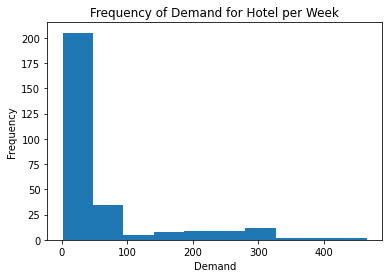

In [24]:
# plot 
plt.hist(x = df["arrivals"])

# format
plt.title("Frequency of Demand for Hotel per Week")
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.show()

In [25]:
# log-arrivals -- can't log a 0 variable... convert to 1
df["ln_arrivals"] = [np.log(1) if x == 0 else np.log(x) for x in df["arrivals"]]

# log-price 
df["ln_price"] = np.log(df["avg_price_per_room"])

In [26]:
# define variables 
y = df["ln_arrivals"]
X = df[['week', 'ln_price', 'peak',
        'Room_Type 2','Room_Type 4','Room_Type 5','Room_Type 6','Room_Type 7'
       ]] # peak

# add constant 
X = sm.add_constant(X)

# model 4
model4 = sm.OLS(y, X)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_arrivals   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     149.8
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           2.58e-96
Time:                        14:28:17   Log-Likelihood:                -342.07
No. Observations:                 288   AIC:                             702.1
Df Residuals:                     279   BIC:                             735.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.7001      0.535      6.921      0.000       2.648       4.752
week           -0.0104      0.004     -2.547      0.011      -0.018      -0.002
ln_price        0.3613      0.117      3.095      0.002       0.132       0.591
peak            0.0832      0.127      0.654      0.514      -0.167       0.334
Room_Type 2    -3.5381      0.152    -23.280      0.000      -3.837      -3.239
Room_Type 4    -1.7888      0.146    -12.271      0.000      -2.076      -1.502
Room_Type 5    -4.4422      0.174    -25.525      0.000      -4.785      -4.100
Room_Type 6    -3.8311      0.167    -22.928      0.000      -4.160      -3.502
Room_Type 7    -4.8173      0.205    -23.497      0.000      -5.221      -4.414
==============================================================================
Omnibus:                        9.201   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.334
Skew:                          -0.412   Prob(JB):                      0.00940
Kurtosis:                       2.686   Cond. No.                         340.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This offers a significant (0.1) boost in R-square, however, peak becomes insignificant. Let's try another Model without Peak as a variable

### Model 5

In [27]:
# define variables 
y = df["ln_arrivals"]
X = df[['week', 'avg_price_per_room',
        'Room_Type 2','Room_Type 4','Room_Type 5','Room_Type 6','Room_Type 7'
       ]] # peak

# add constant 
X = sm.add_constant(X)

# model 
model5 = sm.OLS(y, X)
results5 = model5.fit()
results5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_arrivals   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     175.7
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           1.56e-98
Time:                        14:28:17   Log-Likelihood:                -339.49
No. Observations:                 288   AIC:                             695.0
Df Residuals:                     280   BIC:                             724.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.7289      0.196     24.100      0.000       4.343       5.115
week                  -0.0085      0.003     -2.559      0.011      -0.015      -0.002
avg_price_per_room     0.0063      0.002      3.897      0.000       0.003       0.010
Room_Type 2           -3.5384      0.150    -23.536      0.000      -3.834      -3.242
Room_Type 4           -1.8481      0.146    -12.635      0.000      -2.136      -1.560
Room_Type 5           -4.5389      0.175    -25.865      0.000      -4.884      -4.193
Room_Type 6           -4.1283      0.201    -20.545      0.000      -4.524      -3.733
Room_Type 7           -5.2345      0.246    -21.320      0.000      -5.718      -4.751
==============================================================================
Omnibus:                        9.007   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.345
Skew:                          -0.424   Prob(JB):                      0.00935
Kurtosis:                       2.754   Cond. No.                         900.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All variables are significant, now the question is which of model 3 or model 5 performs the best. 

## Test Model

create the test model data.

In [28]:
# prepare data 
df_test = test.groupby(['week', 'month', 'room_type_reserved']).agg({'arrivals': 'sum', 'avg_price_per_room': 'mean'})
df_test = df_test.reset_index()
room_cat = pd.get_dummies(df_test["room_type_reserved"])
df_test = pd.concat([df_test, room_cat], axis = 1)
df_test["ln_price"] = np.log(df_test["avg_price_per_room"])
df_test["ln_arrivals"] = [np.log(1) if x == 0 else np.log(x) for x in df_test["arrivals"]]

# add peak 
df_test["peak"] = [1 if x in [6, 9, 10, 12] else 0 for x in df_test["month"]]
df_test

# add predictions model 3 
df_test["pred_mod3"] = 193.6281 - 0.8361 * df_test["week"] + 0.2327 * df_test["avg_price_per_room"] + 21.8498 * df_test["peak"]  -193.8957 * df_test["Room_Type 2"] -163.9233 * df_test["Room_Type 4"] -203.7756 * df_test["Room_Type 5"] -214.0758 * df_test["Room_Type 6"] -218.4495 * df_test["Room_Type 7"]
df_test["pred_mod5"] = 4.7289 - 0.0085 * df_test["week"] + 0.0063 * df_test["avg_price_per_room"] - 3.5384 * df_test["Room_Type 2"] - 1.8481 * df_test["Room_Type 4"] - 4.5389 * df_test["Room_Type 5"] - 4.1283 * df_test["Room_Type 6"] - 5.2345 * df_test["Room_Type 7"]

# fix prediction 3 - predictions must be at least 0 
df_test["pred_mod3"] = [0 if x < 0 else x for x in df_test["pred_mod3"]]
df_test

# unlog prediction 5
df_test["pred_mod5"] = [math.exp(1) if x <= 0 else math.exp(x) for x in df_test["pred_mod5"]]
df_test

,week,month,room_type_reserved,arrivals,avg_price_per_room,Room_Type 1,Room_Type 2,Room_Type 4,Room_Type 5,Room_Type 6,Room_Type 7,ln_price,ln_arrivals,peak,pred_mod3,pred_mod5
0,33.0,8.0,Room_Type 1,141,118.537305,1,0,0,0,0,0,4.775228,4.948760,0,193.620431,180.401518
1,33.0,8.0,Room_Type 2,11,111.720000,0,1,0,0,0,0,4.715996,2.397895,0,0.000000,5.022039
2,33.0,8.0,Room_Type 4,58,144.762414,0,0,1,0,0,0,4.975094,4.060443,0,35.799714,33.525395
3,33.0,8.0,Room_Type 5,1,149.000000,0,0,0,1,0,0,5.003946,0.000000,0,0.000000,2.335439
4,33.0,8.0,Room_Type 6,9,221.255556,0,0,0,0,1,0,5.399318,2.197225,0,3.447168,5.551177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,49.0,12.0,Room_Type 7,1,182.180000,0,0,0,0,0,1,5.204995,0.000000,1,0.000000,1.253117
108,50.0,12.0,Room_Type 1,127,84.068976,1,0,0,0,0,0,4.431638,4.844187,1,193.235751,125.654308
109,50.0,12.0,Room_Type 4,17,123.188235,0,0,1,0,0,0,4.813714,2.833213,1,38.415502,25.327376
110,50.0,12.0,Room_Type 5,1,106.000000,0,0,0,1,0,0,4.663439,0.000000,1,0.000000,1.541568


#### Model 3

##### sMAPE

In [29]:
df_test = df_test[df_test["arrivals"] > 1] # predictions at 0 gives a very high sMAPE 
def mape(row):
    return abs(row.pred_mod3 - row.arrivals) / ((abs(row.arrivals) + abs(row.pred_mod3))/2)

smape = df_test.apply(mape, axis=1).sum() * (1/len(df)) * 100
smape

33.45268250603814

##### MSE

In [30]:
mse = mean_squared_error(df_test["arrivals"], df_test["pred_mod3"])
mse

2072.55507192439

##### SSE

In [31]:
sse = np.sum(np.power(df_test["arrivals"] - df_test["pred_mod3"], 2))
sse

209328.0622643634

#### Model 5 

##### sMAPE

In [32]:
def mape(row):
    return abs(row.pred_mod5 - row.ln_arrivals) / ((abs(row.ln_arrivals) + abs(row.pred_mod3))/2)

smape = df_test.apply(mape, axis=1).sum() * (1/len(df)) * 100
smape

51.48351091808559

##### MSE

In [33]:
mse = mean_squared_error(df_test["arrivals"], df_test["pred_mod5"])
mse

3354.8100518941733

##### SSE

In [34]:
sse = np.sum(np.power(df_test["arrivals"] - df_test["pred_mod5"], 2))
sse

338835.8152413115

Model 3 is better (smaller sMAPE, MSE, and SSE)! 

## Linear Optimization Model 

 Once the predictive model is completed, the optimization can start. As mentioned, our objective is to find which combination of prices for each room type maximizes the hotel's total revenue. 
 
 In our model, we only consider room type 1, 2, 4, 5, and 6.

#### Initialize Model 

In [35]:
m = gp.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-31


#### Decision variables

In [36]:
indices = []
# t = 12 --> we want to predict for the next 12 weeks. 
for t in range(33, 51):
    # i = 5 --> there are 5 room types
    for i in range(5): 
        indices=indices+[(i,t)]

# add variables 
price = m.addVars(indices, vtype = GRB.CONTINUOUS, name = 'Price', lb = 1)

## Objective Function

Demand will be a function of price; therefore, let's create this function. 

In [37]:
def demand(i, t, p):
    xdem = 193.6281 - 0.8361 * t + 0.2327 * p
    if i == 1: 
        xdem -= 193.8957
    elif i == 2: 
        xdem -= 163.9233 
    elif i == 3: 
        xdem -= 203.7756
    elif i == 4: 
        xdem -= 214.0758
    if t in [36, 37, 38, 39, 40, 41, 42, 43, 44, 49, 50, 51, 52]: 
        xdem += 21.8498
    return xdem

In [38]:
# Define objective function
m.setObjective(gp.quicksum((price[i, t]) * demand(i, t, price[i, t])
                            for i in range(5) for t in range(33, 51)), 
                            GRB.MAXIMIZE)

### Constraints

#### Pricing Constraint

The price of each room at each time must remain between the minimum and maximum price offered by the hotel in the dataset.

In [39]:
# find min and max prices for each room type 

room1 = train[train["room_type_reserved"] == "Room_Type 1"]
price_room1 = room1[["week","avg_price_per_room"]]
price_per_week_room1 = price_room1.groupby("week").mean()
min_room1 = price_per_week_room1["avg_price_per_room"].min() * (1 - 0.25)
max_room1 = price_per_week_room1["avg_price_per_room"].max() * (1 + 0.25)


room2 = train[train["room_type_reserved"] == "Room_Type 2"]
price_room2 = room2[["week","avg_price_per_room"]]
price_per_week_room2 = price_room2.groupby("week").mean()
min_room2 = price_per_week_room2["avg_price_per_room"].min() * (1 - 0.25)
max_room2 = price_per_week_room2["avg_price_per_room"].max() * (1 + 0.25)


room4 = train[train["room_type_reserved"] == "Room_Type 4"]
price_room4 = room4[["week","avg_price_per_room"]]
price_per_week_room4 = price_room4.groupby("week").mean()
min_room4 = price_per_week_room4["avg_price_per_room"].min() * (1 - 0.25)
max_room4 = price_per_week_room4["avg_price_per_room"].max() * (1 + 0.25)


room5 = train[train["room_type_reserved"] == "Room_Type 5"]
price_room5 = room5[["week","avg_price_per_room"]]
price_per_week_room5 = price_room5.groupby("week").mean()
min_room5 = price_per_week_room1["avg_price_per_room"].min() * (1 - 0.25)
max_room5 = price_per_week_room1["avg_price_per_room"].max() * (1 + 0.25)


room6 = train[train["room_type_reserved"] == "Room_Type 6"]
price_room6 = room1[["week","avg_price_per_room"]]
price_per_week_room6 = price_room6.groupby("week").mean()
min_room6 = price_per_week_room6["avg_price_per_room"].min() * (1 - 0.25)
max_room6 = price_per_week_room6["avg_price_per_room"].max() * (1 + 0.25)

In [40]:
for t in range(33, 51):
    c1 = m.addConstr(price[0, t] >= min_room1)
    c2 = m.addConstr(price[0, t] <= max_room1)
    
    c3 = m.addConstr(price[1, t] >= min_room2)
    c4 = m.addConstr(price[1, t] <= max_room2)

    c5 = m.addConstr(price[2, t] >= min_room4)
    c6 = m.addConstr(price[2, t] <= max_room4)

    c7 = m.addConstr(price[3, t] >= min_room5)
    c8 = m.addConstr(price[3, t] <= max_room5)

    c9 = m.addConstr(price[4, t] >= min_room6)
    c10 = m.addConstr(price[4, t] <= max_room6)

#### Capacity Constraint

The demand cannot go over the maximum number of rooms available per room type at any time for each room type

In [41]:
# df Room Type 1
df1 = df_dup[df_dup['room_type_reserved'].str.contains('Room_Type 1', na = False)]

# df Room Type 2
df2 = df_dup[df_dup['room_type_reserved'].str.contains('Room_Type 2', na = False)]

# df Room Type 4
df4 = df_dup[df_dup['room_type_reserved'].str.contains('Room_Type 4', na = False)]

# df Room Type 5
df5 = df_dup[df_dup['room_type_reserved'].str.contains('Room_Type 5', na = False)]

# df Room Type 6
df6 = df_dup[df_dup['room_type_reserved'].str.contains('Room_Type 6', na = False)]

In [42]:
# Room 1

# find arrivals and departure for each day 
df_date1 = df1.groupby('date').agg({'arrivals': 'sum', 'depart': 'sum'})

# calculate the difference between arrival and depart
df_date1['flow'] = df_date1['arrivals'] - df_date1['depart']

# calculate the running total of the differences
df_date1['running_total'] = df_date1['flow'].cumsum()


# max number of rooms 
room1 = df_date1[df_date1['running_total'] == df_date1['running_total'].max()].iloc[:, 3]
room1

date
2017-09-18    267
Name: running_total, dtype: int64

In [43]:
# Room 2

# find arrivals and departure for each day 
df_date2 = df2.groupby('date').agg({'arrivals': 'sum', 'depart': 'sum'})

# calculate the difference between arrival and depart
df_date2['flow'] = df_date2['arrivals'] - df_date2['depart']

# calculate the running total of the differences
df_date2['running_total'] = df_date2['flow'].cumsum()


# max number of rooms 
room2 = df_date2[df_date2['running_total'] == df_date2['running_total'].max()].iloc[:, 3]
room2

date
2017-10-21    15
Name: running_total, dtype: int64

In [45]:
# Room 4

# find arrivals and departure for each day 
df_date4 = df4.groupby('date').agg({'arrivals': 'sum', 'depart': 'sum'})

# calculate the difference between arrival and depart
df_date4['flow'] = df_date4['arrivals'] - df_date4['depart']

# calculate the running total of the differences
df_date4['running_total'] = df_date4['flow'].cumsum()


# max number of rooms 
room4 = df_date4[df_date4['running_total'] == df_date4['running_total'].max()].iloc[:, 3]
room4

date
2018-12-30    78
Name: running_total, dtype: int64

In [46]:
# Room 5

# find arrivals and departure for each day 
df_date5 = df5.groupby('date').agg({'arrivals': 'sum', 'depart': 'sum'})

# calculate the difference between arrival and depart
df_date5['flow'] = df_date5['arrivals'] - df_date5['depart']

# calculate the running total of the differences
df_date5['running_total'] = df_date5['flow'].cumsum()


# max number of rooms 
room5 = df_date5[df_date5['running_total'] == df_date5['running_total'].max()].iloc[:, 3]
room5

date
2018-02-06    13
Name: running_total, dtype: int64

In [47]:
# Room 6

# find arrivals and departure for each day 
df_date6 = df6.groupby('date').agg({'arrivals': 'sum', 'depart': 'sum'})

# calculate the difference between arrival and depart
df_date6['flow'] = df_date6['arrivals'] - df_date6['depart']

# calculate the running total of the differences
df_date6['running_total'] = df_date6['flow'].cumsum()


# max number of rooms 
room6 = df_date6[df_date6['running_total'] == df_date6['running_total'].max()].iloc[:, 3]
room6

date
2018-12-31    11
Name: running_total, dtype: int64

In [58]:
print('room 1', room1)
print('room 2', room2)
print('room 4', room4)
print('room 5', room5)
print('room 6', room6)

room 1 date
2017-09-18    267
Name: running_total, dtype: int64
room 2 date
2017-10-21    15
Name: running_total, dtype: int64
room 4 date
2018-12-30    78
Name: running_total, dtype: int64
room 5 date
2018-02-06    13
Name: running_total, dtype: int64
room 6 date
2018-12-31    11
Name: running_total, dtype: int64


In [49]:
for t in range(33, 51): 
    c11 = m.addConstr(demand(0, t, price[0, t]) <= room1)

    c12 = m.addConstr(demand(1, t, price[1, t]) <= room2)
    
    c13 = m.addConstr(demand(2, t, price[2, t]) <= room4)
    
    c14 = m.addConstr(demand(3, t, price[3, t]) <= room5)
    
    c15 = m.addConstr(demand(4, t, price[4, t]) <= room6)

#### Price Ladder Constraint

The last constraint was a “price-ladder” constraint to ensure the model remained sane. For hotels, the room types have a particular quality order where certain rooms (such as suites) must be priced higher than standard-type rooms; if not, all the demand would go to the suite.

What is the approximate price (using max price)?

In [50]:
print('room1: ', max_room1)
print('room2: ', max_room2)
print('room4: ', max_room4)
print('room5: ', max_room5)
print('room6: ', max_room6)

room1:  143.00733805668017
room2:  181.64499999999998
room4:  181.6272727272727
room5:  143.00733805668017
room6:  143.00733805668017


Price needs to remain above the minimum of the other "lesser-quality" room. Adds more flexbility than using the actual price.

In [51]:
for t in range(33, 51): 
    c16 = m.addConstr(price[1, t] >= min_room1)
    
    c17 = m.addConstr(price[1, t] >= min_room5)
    
    c18 = m.addConstr(price[1, t] >= min_room6)

    c19 = m.addConstr(price[2, t] >= min_room1)

    c20 = m.addConstr(price[2, t] >= min_room5)

    c21 = m.addConstr(price[2, t] >= min_room6)

### Optimization

#### Optimimal Value

In [52]:
status = m.optimize()
ObjectiveValue=m.objVal
# Output and analysis
print("Objective value is ", ObjectiveValue)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 378 rows, 90 columns and 378 nonzeros
Model fingerprint: 0x6a2c601a
Model has 90 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [4e-01, 2e+02]
  QObjective range [5e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+02]
Presolve removed 378 rows and 90 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective 7.13839000e+05
Objective value is  713839.0003957548


#### Optimal Solution

In [53]:
# Create a data table using pandas
data = []
for t in range(33, 50):
    row = {}
    for i in range(5):
        row[f"i={i}"] = np.round(price[i, t].x, 2)
    row["t"] = t
    data.append(row)
table = pd.DataFrame(data)
table = table.set_index("t")

# Print the table
table

,i=0,i=1,i=2,i=3,i=4
t,,,,,
33,143.01,181.64,181.63,143.01,51.85
34,143.01,181.64,181.63,143.01,51.85
35,143.01,181.64,181.63,143.01,51.85
36,143.01,101.06,181.63,134.93,143.01
37,143.01,104.66,181.63,138.52,143.01
38,143.01,108.25,181.63,142.11,143.01
39,143.01,111.84,181.63,143.01,143.01
40,143.01,115.44,181.63,143.01,143.01
41,143.01,119.03,181.63,143.01,143.01


## Compare with Actual Results

In [54]:
comp = test[(test["date"] >= '2018-08-15') & (test["date"] <= '2018-12-15')]

# drop un-optimized room
comp = comp[(comp["room_type_reserved"] != "Room_Type 3") | (comp["room_type_reserved"] != "Room_Type 7")]

In [55]:
comp.sum()["avg_price_per_room"]

/var/folders/zw/fqrrp0nj2jj2nb862n366m6c0000gn/T/ipykernel_22357/4172391769.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  comp.sum()["avg_price_per_room"]


710900.17

### Revenue in 1 yr

In [56]:
train.sum()["avg_price_per_room"]

/var/folders/zw/fqrrp0nj2jj2nb862n366m6c0000gn/T/ipykernel_22357/2003081733.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.sum()["avg_price_per_room"]


1581956.33

In [61]:
# expected increase with our 2.6% forecasted increase
1581956.33 * 0.004

6327.825320000001

## Shaddow Prices

In [59]:
Shaddow_c1=round(c1.Pi,2)
Shaddow_c2=round(c2.Pi,2)
Shaddow_c3=round(c3.Pi,2)
Shaddow_c4=round(c4.Pi,2)
Shaddow_c5=round(c5.Pi,2)
Shaddow_c6=round(c6.Pi,2)
Shaddow_c7=round(c7.Pi,2)
Shaddow_c8=round(c8.Pi,2)
Shaddow_c9=round(c9.Pi,2)
Shaddow_c10=round(c10.Pi,2)
Shaddow_c11=round(c11.Pi,2)
Shaddow_c12=round(c12.Pi,2)
Shaddow_c13=round(c13.Pi,2)
Shaddow_c14=round(c14.Pi,2)
Shaddow_c15=round(c15.Pi,2)
Shaddow_c16=round(c16.Pi,2)
Shaddow_c17=round(c17.Pi,2)
Shaddow_c18=round(c18.Pi,2)
Shaddow_c19=round(c19.Pi,2)
Shaddow_c20=round(c20.Pi,2)
Shaddow_c21=round(c21.Pi,2)


# dict 
shadow_dict = {}
for i in range(1, 22):
    shadow_name = "Shaddow_c" + str(i)
    shadow_value = globals()[shadow_name]
    shadow_dict["c" + str(i)] = shadow_value

# df 
sp = pd.DataFrame.from_dict(shadow_dict, orient="index", columns=["Shadow Price"])
sp

,Shadow Price
c1,-0.00
c2,240.23
c3,-0.00
c4,0.00
c5,-0.00
c6,94.28
c7,-0.00
c8,36.45
c9,-0.00
c10,26.15
